In [1]:
import os
os.chdir('..')

In [38]:
import numpy as np
import scipy as sp
import datajoint as dj
import matplotlib.pyplot as plt

In [39]:
from pipeline import lab, experiment, tracking, ephys, psth
from pipeline import plot
from pipeline.plot import behavior_plot, unit_characteristic_plot

# Top level ***ephys*** diagram

In [3]:
ephys_erd = ((dj.ERD(ephys.Unit)-2) + dj.ERD(ephys.TrialSpikes)
             + (dj.ERD(experiment.BrainLocation)-1)
             + dj.ERD(ephys.ProbeInsertion.InsertionLocation)
             + dj.ERD(psth.UnitSelectivity) + (dj.ERD(psth.PeriodSelectivity) - 1))

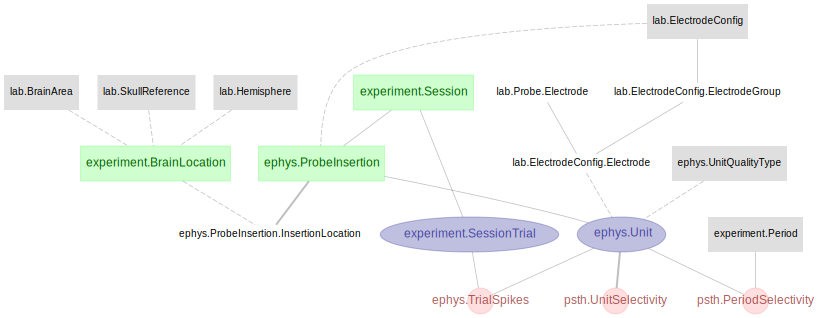

In [4]:
ephys_erd

# Top level ***behavior*** diagram

In [5]:
behav_erd = (dj.ERD(experiment.SessionTrial) - 1 
             + (dj.ERD(experiment.BrainLocation)-1) 
             + (dj.ERD(experiment.BehaviorTrial) + 1 - 1) 
             + (dj.ERD(experiment.PhotostimTrial) + 1 - 1)) 

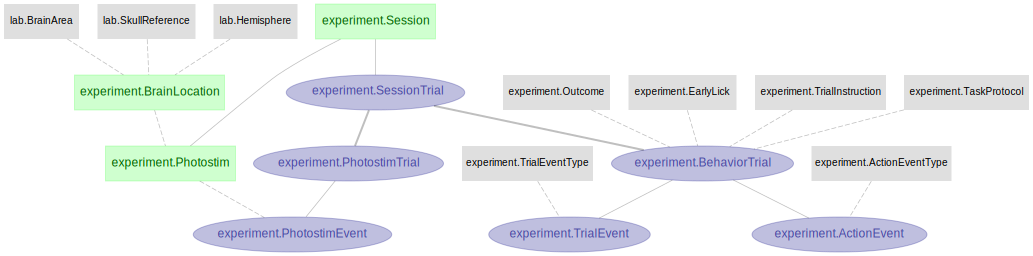

In [6]:
behav_erd

# Browsing of subjects

In [40]:
lab.Subject()

subject_id institution 6 digit animal ID,username,cage_number institution 6 digit animal ID,date_of_birth format: yyyy-mm-dd,sex,animal_source
412330,daveliu,154522,2017-12-05,M,Jackson labs
412753,daveliu,154570,2017-12-07,M,Jackson labs
413950,daveliu,155585,2017-12-21,M,Jackson labs
418279,daveliu,155593,2018-02-02,M,Jackson labs
428047,daveliu,158986,2018-05-16,M,Jackson labs
428048,daveliu,158987,2018-05-16,M,Jackson labs
432570,daveliu,161126,2018-06-28,M,Jackson labs


### Query one subject

In [43]:
# restrict by string
lab.Subject & 'subject_id=412330'

subject_id institution 6 digit animal ID,username,cage_number institution 6 digit animal ID,date_of_birth format: yyyy-mm-dd,sex,animal_source
412330,daveliu,154522,2017-12-05,M,Jackson labs


In [15]:
# restrict by dictionary
lab.Subject & {'subject_id': 412330}

subject_id institution 6 digit animal ID,username,cage_number institution 6 digit animal ID,date_of_birth format: yyyy-mm-dd,sex,animal_source
412330,daveliu,154522,2017-12-05,M,Jackson labs


In [16]:
lab.Subject & {'sex': 'm'}

subject_id institution 6 digit animal ID,username,cage_number institution 6 digit animal ID,date_of_birth format: yyyy-mm-dd,sex,animal_source
412330,daveliu,154522,2017-12-05,M,Jackson labs
412753,daveliu,154570,2017-12-07,M,Jackson labs
413950,daveliu,155585,2017-12-21,M,Jackson labs
418279,daveliu,155593,2018-02-02,M,Jackson labs
428047,daveliu,158986,2018-05-16,M,Jackson labs
428048,daveliu,158987,2018-05-16,M,Jackson labs
432570,daveliu,161126,2018-06-28,M,Jackson labs


### Fetch back the subject key

In [17]:
subj_412330 = (lab.Subject & {'subject_id': 412330}).fetch1('KEY')  # "fetch1()" because we know there's only one

In [18]:
subj_412330

{'subject_id': 412330}

In [19]:
male_subjs = (lab.Subject & {'sex': 'm'}).fetch('KEY')  # "fetch()" for fetching multiple

In [20]:
male_subjs

[{'subject_id': 412330},
 {'subject_id': 412753},
 {'subject_id': 413950},
 {'subject_id': 418279},
 {'subject_id': 428047},
 {'subject_id': 428048},
 {'subject_id': 432570},
 {'subject_id': 432572},
 {'subject_id': 432998},
 {'subject_id': 435884},
 {'subject_id': 439457},
 {'subject_id': 440010}]

# Browsing of sessions

In [36]:
# Get sessions with units
sessions = experiment.Session & ephys.Unit
sessions

subject_id institution 6 digit animal ID,session session number,session_date,username,rig
412330,15,2018-07-16,daveliu,RRig
412753,41,2018-07-10,daveliu,RRig
413950,21,2018-10-23,daveliu,RRig
432572,14,2018-11-25,daveliu,RRig
432572,15,2018-11-26,daveliu,RRig
432998,16,2019-01-13,daveliu,RRig
435884,14,2018-12-01,daveliu,RRig


In [44]:
# List all sessions and the ProbeInsertion counts for each
sessions=experiment.Session.aggr(ephys.ProbeInsertion, probe_insert_count='count(*)') & 'probe_insert_count > 1'
sessions

subject_id institution 6 digit animal ID,session session number,probe_insert_count calculated attribute
412330,15,2
412753,41,2
413950,21,2
432572,14,2
432572,15,2


In [24]:
# query 1 session
experiment.Session & {'session': 15, 'subject_id': 412330}

subject_id institution 6 digit animal ID,session session number,session_date,username,rig
412330,15,2018-07-16,daveliu,RRig


In [45]:
# get session key
session_key = (experiment.Session & {'session': 15, 'subject_id': 412330}).fetch1('KEY')

# Browsing of units for this session
#### Keep in mind that units may come from different ***ProbeInsertion***

In [46]:
unit_erd = (dj.ERD(ephys.Unit) - 1) + (dj.ERD(ephys.Unit) + 1)

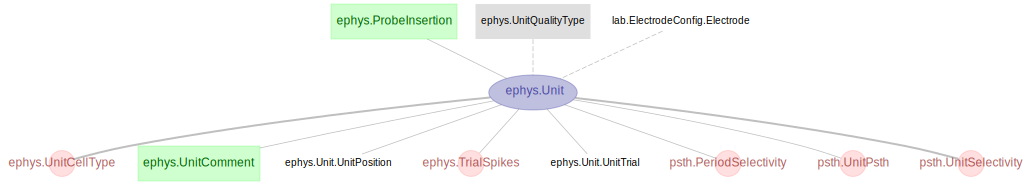

In [47]:
unit_erd

In [48]:
ephys.Unit & session_key

subject_id institution 6 digit animal ID,session session number,insertion_number,unit,unit_uid unique across sessions/animals,unit_quality,probe unique identifier for this model of probe (e.g. part number),electrode_config_id hash of the group and group_member (ensure uniqueness),electrode_group electrode group,electrode electrode,"unit_posx (um) estimated x position of the unit relative to probe's (0,0)","unit_posy (um) estimated y position of the unit relative to probe's (0,0)",spike_times (s) from the start of the first data point used in clustering,unit_amp,unit_snr,waveform average spike waveform
412330,15,1,1,1,all,15131808323,18fd56922c9f76773ad5ad288619ab51,0,2,22.84069061279297,3.5793862342834473,=BLOB=,45.626198,4.943878,=BLOB=
412330,15,1,2,2,all,15131808323,18fd56922c9f76773ad5ad288619ab51,0,4,28.308536529541016,16.114704132080078,=BLOB=,221.73726,10.427825,=BLOB=
412330,15,1,3,3,all,15131808323,18fd56922c9f76773ad5ad288619ab51,0,3,3.5463621616363525,21.084684371948242,=BLOB=,113.18932,3.5160778,=BLOB=
412330,15,1,4,4,all,15131808323,18fd56922c9f76773ad5ad288619ab51,0,3,5.110103607177734,23.70351791381836,=BLOB=,143.80943,4.6012316,=BLOB=
412330,15,1,5,5,all,15131808323,18fd56922c9f76773ad5ad288619ab51,0,2,30.303544998168945,2.7377524375915527,=BLOB=,115.72967,5.8627715,=BLOB=
412330,15,1,6,6,all,15131808323,18fd56922c9f76773ad5ad288619ab51,0,2,31.89282989501953,3.302384376525879,=BLOB=,69.38274,5.770551,=BLOB=
412330,15,1,7,7,good,15131808323,18fd56922c9f76773ad5ad288619ab51,0,3,7.404426574707031,23.034358978271484,=BLOB=,427.98932,13.06085,=BLOB=


In [49]:
good_units = ephys.Unit & session_key & {'unit_quality': 'good'} & {'insertion_number': 1}
good_units

subject_id institution 6 digit animal ID,session session number,insertion_number,unit,unit_uid unique across sessions/animals,unit_quality,probe unique identifier for this model of probe (e.g. part number),electrode_config_id hash of the group and group_member (ensure uniqueness),electrode_group electrode group,electrode electrode,"unit_posx (um) estimated x position of the unit relative to probe's (0,0)","unit_posy (um) estimated y position of the unit relative to probe's (0,0)",spike_times (s) from the start of the first data point used in clustering,unit_amp,unit_snr,waveform average spike waveform
412330,15,1,7,7,good,15131808323,18fd56922c9f76773ad5ad288619ab51,0,3,7.404426574707031,23.034358978271484,=BLOB=,427.98932,13.06085,=BLOB=
412330,15,1,8,8,good,15131808323,18fd56922c9f76773ad5ad288619ab51,0,3,3.042593002319336,19.83121109008789,=BLOB=,290.44583,7.659547,=BLOB=
412330,15,1,12,12,good,15131808323,18fd56922c9f76773ad5ad288619ab51,0,4,32.344425201416016,16.04660415649414,=BLOB=,225.7262,11.071866,=BLOB=
412330,15,1,18,18,good,15131808323,18fd56922c9f76773ad5ad288619ab51,0,11,6.8651227951049805,96.26170349121094,=BLOB=,296.88046,12.259954,=BLOB=
412330,15,1,34,34,good,15131808323,18fd56922c9f76773ad5ad288619ab51,0,15,2.5680699348449707,142.50448608398438,=BLOB=,231.31876,8.671488,=BLOB=
412330,15,1,35,35,good,15131808323,18fd56922c9f76773ad5ad288619ab51,0,21,15.262028694152832,201.51885986328125,=BLOB=,241.5961,7.549255,=BLOB=
412330,15,1,38,38,good,15131808323,18fd56922c9f76773ad5ad288619ab51,0,18,46.01060485839844,161.53170776367188,=BLOB=,330.37268,11.911634,=BLOB=


## Unit selectivity

In [11]:
psth.UnitSelectivity & good_units

subject_id institution 6 digit animal ID,session session number,insertion_number,unit,unit_selectivity
412330,15,1,7,ipsi-selective
412330,15,1,8,contra-selective
412330,15,1,12,contra-selective
412330,15,1,18,contra-selective
412330,15,1,38,contra-selective
412330,15,1,53,ipsi-selective
412330,15,1,82,contra-selective


### Pick one unit

In [50]:
unit_key = (psth.UnitSelectivity & good_units & 'unit=82').fetch1('KEY')
unit_key                                                                 

{'insertion_number': 1, 'session': 15, 'subject_id': 412330, 'unit': 82}

In [56]:
unit_key = (psth.UnitSelectivity & good_units & 'unit_selectivity="contra-selective"').fetch('KEY')
unit_key

[{'insertion_number': 1, 'session': 15, 'subject_id': 412330, 'unit': 8},
 {'insertion_number': 1, 'session': 15, 'subject_id': 412330, 'unit': 12},
 {'insertion_number': 1, 'session': 15, 'subject_id': 412330, 'unit': 18},
 {'insertion_number': 1, 'session': 15, 'subject_id': 412330, 'unit': 38},
 {'insertion_number': 1, 'session': 15, 'subject_id': 412330, 'unit': 82},
 {'insertion_number': 1, 'session': 15, 'subject_id': 412330, 'unit': 97},
 {'insertion_number': 1, 'session': 15, 'subject_id': 412330, 'unit': 131},
 {'insertion_number': 1, 'session': 15, 'subject_id': 412330, 'unit': 224},
 {'insertion_number': 1, 'session': 15, 'subject_id': 412330, 'unit': 259},
 {'insertion_number': 1, 'session': 15, 'subject_id': 412330, 'unit': 289},
 {'insertion_number': 1, 'session': 15, 'subject_id': 412330, 'unit': 301},
 {'insertion_number': 1, 'session': 15, 'subject_id': 412330, 'unit': 305},
 {'insertion_number': 1, 'session': 15, 'subject_id': 412330, 'unit': 308},
 {'insertion_number

### Unit PSTH

In [13]:
upsth_erd = (dj.ERD(psth.UnitPsth) - 1)

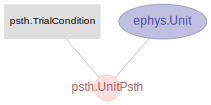

In [14]:
upsth_erd

In [15]:
psth.TrialCondition()

trial_condition_id hash of trial_condition_arg,trial_condition_desc trial condition description,trial_condition_func trial retrieval function,trial_condition_arg trial retrieval arguments
2d893587b6112ca356ce8a945abbcacb,all_noearlylick_both_alm_stim,_get_trials_include_stim,=BLOB=
42bb9a19b2b308454762247e4c3bd863,good_noearlylick_hit,_get_trials_exclude_stim,=BLOB=
90a437e5aa48baa8b16920c6ee0d67a6,good_noearlylick_left_miss,_get_trials_exclude_stim,=BLOB=
ace70cc388c9413d9b0541c512bdaf03,good_noearlylick_right_hit,_get_trials_exclude_stim,=BLOB=
afa05676a85b4827117ef2012d096b78,good_noearlylick_right_miss,_get_trials_exclude_stim,=BLOB=
c36c9b367f738156aa023abd98e44271,all_noearlylick_both_alm_nostim_right,_get_trials_exclude_stim,=BLOB=
c97ecd16d4db88d1a3a1b44b80341ff3,good_noearlylick_left_hit,_get_trials_exclude_stim,=BLOB=


In [51]:
unit_psth = psth.UnitPsth * psth.TrialCondition & unit_key & 'trial_condition_desc = "good_noearlylick_right_hit"'

In [52]:
psth_trace, edges = unit_psth.fetch1('unit_psth')

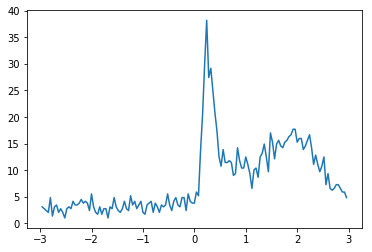

In [53]:
plt.plot(edges[1:], psth_trace)

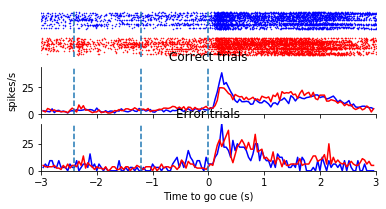

In [54]:
plot.unit_psth(unit_key)